# Get libraries

Authors: W.T. Chung, M. Saboo, C.-Z. Tan.
This code was modified from the detectron tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [1]:
import torch
import sys
import multiprocessing
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

print('CPUs:', multiprocessing.cpu_count())

__Python VERSION: 3.6.15 | packaged by conda-forge | (default, Dec  3 2021, 18:49:41) 
[GCC 9.4.0]
__pyTorch VERSION: 1.10.0+cu102
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
CPUs: 4


In [2]:
# Some basic setup:
# Setup detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt
import json
import pandas as pd

In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetMapper, build_detection_test_loader


In [9]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds

from detectron2.engine import DefaultTrainer


import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)
        
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

# Get Data

In [3]:
lvis_train_dict = detectron2.data.datasets.load_coco_json('./data/detectron_lvis_train_data.json', './data/train2017','lvis_train')

DatasetCatalog.register("lvis_train",lambda train='train': lvis_train_dict)

lvis_val_dict = detectron2.data.datasets.load_coco_json('./data/detectron_lvis_val_data.json', './data/train2017','lvis_val')

DatasetCatalog.register("lvis_val",lambda val='val': lvis_val_dict)

lvis_test_dict = detectron2.data.datasets.load_coco_json('./data/detectron_lvis_test_data.json', './data/train2017','lvis_test')

DatasetCatalog.register("lvis_test",lambda test='test': lvis_test_dict)

[06/02 23:13:36 d2.data.datasets.coco]: Loading ./data/detectron_lvis_train_data.json takes 5.61 seconds.
WARNING [06/02 23:13:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/02 23:13:36 d2.data.datasets.coco]: Loaded 14206 images in COCO format from ./data/detectron_lvis_train_data.json
WARNING [06/02 23:13:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/02 23:13:38 d2.data.datasets.coco]: Loaded 2375 images in COCO format from ./data/detectron_lvis_val_data.json
WARNING [06/02 23:13:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/02 23:13:39 d2.data.datasets.coco]: Loaded 2387 images in COCO format from ./data/detectron_lvis_test_data.json


# Visualize Ground Truth

In [6]:
truth_list = []
for d in lvis_test_dict[66:72]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get('lvis_test'), scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    truth_list.append(out.get_image()[:, :, :])

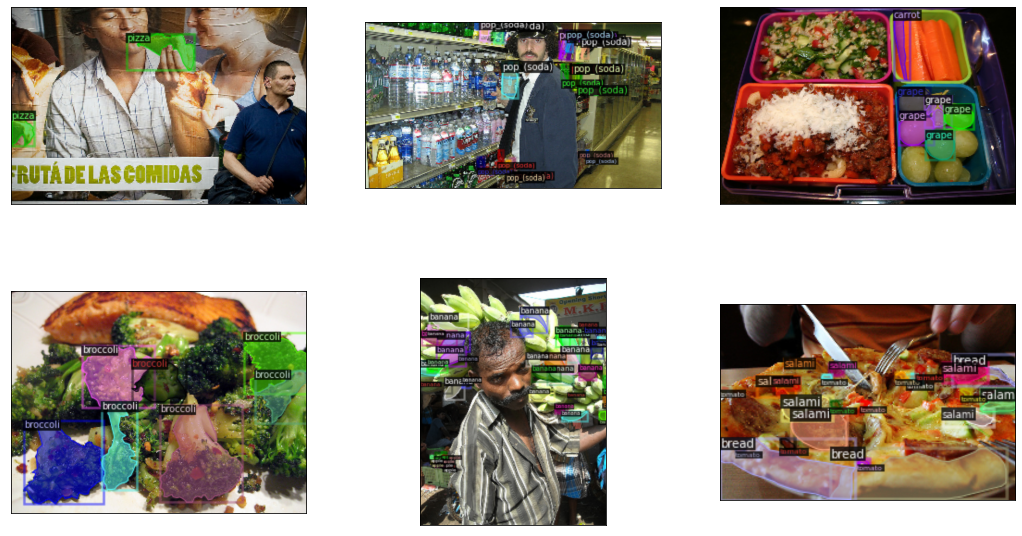

In [7]:
x=2
y=3
fig, axs = plt.subplots(x,y, figsize=(18,10), sharey=False,sharex=False)

for i in range(x):
    for j in range(y):
        axs[i,j].imshow(truth_list[j+i*y],interpolation='gaussian')
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
# fig.savefig("./io.pdf", bbox_inches="tight")
fig.savefig("./true_vis.pdf", bbox_inches="tight")

## Train!


In [6]:
torch.cuda.empty_cache()

In [6]:
!nvidia-smi

Tue May 31 15:56:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla T4     On   | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# epochs = 10
it= 25001
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("lvis_train",)
cfg.DATASETS.TEST = ("lvis_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 1e-5  # pick a good LR
cfg.SOLVER.MAX_ITER = it#int(epochs*len(lvis_train_dict)/cfg.SOLVER.IMS_PER_BATCH)  # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.GAMMA = 0.1 # The iteration number to decrease learning rate by GAMMA.
cfg.SOLVER.STEPS = (12001,15001,18001)     #  decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 186  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.SOLVER.CHECKPOINT_PERIOD = 3000
cfg.TEST.EVAL_PERIOD = 1000
cfg.OUTPUT_DIR = './output_train'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [12]:
trainer = MyTrainer(cfg) 
# trainer.resume_or_load(resume=False) # For Iteration 0
trainer.resume_or_load(resume=True) #After first checkpoint
trainer.train()

[05/29 15:19:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/ubuntu/anaconda3/envs/py36/lib/python3.6/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/ubuntu/anaconda3/envs/py36/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/29 15:20:42 d2.utils.events]:  eta: 6:14:12  iter: 15019  total_loss: 1.013  loss_cls: 0.3529  loss_box_reg: 0.2161  loss_mask: 0.2698  loss_rpn_cls: 0.06403  loss_rpn_loc: 0.07394  time: 2.2647  data_time: 0.0656  lr: 1e-06  max_mem: 9475M
[05/29 15:21:28 d2.utils.events]:  eta: 6:13:27  iter: 15039  total_loss: 1.118  loss_cls: 0.3833  loss_box_reg: 0.2488  loss_mask: 0.2947  loss_rpn_cls: 0.08505  loss_rpn_loc: 0.08624  time: 2.2901  data_time: 0.0456  lr: 1e-06  max_mem: 9475M
[05/29 15:22:16 d2.utils.events]:  eta: 6:25:10  iter: 15059  total_loss: 1.101  loss_cls: 0.4001  loss_box_reg: 0.2391  loss_mask: 0.2912  loss_rpn_cls: 0.06752  loss_rpn_loc: 0.08238  time: 2.3299  data_time: 0.0622  lr: 1e-06  max_mem: 9475M
[05/29 15:23:04 d2.utils.events]:  eta: 6:28:57  iter: 15079  total_loss: 1.162  loss_cls: 0.4139  loss_box_reg: 0.2505  loss_mask: 0.296  loss_rpn_cls: 0.08611  loss_rpn_loc: 0.1095  time: 2.3492  data_time: 0.0535  lr: 1e-06  max_mem: 9475M
[05/29 15:23:53 d2.uti

# Evaluate Baseline

In [7]:
coco_test_dict = detectron2.data.datasets.load_coco_json('./data/coco_test_data.json', './data/train2017','coco_test')

[05/31 16:17:32 d2.data.datasets.coco]: Loaded 2383 images in COCO format from ./data/coco_test_data.json


In [8]:
DatasetCatalog.register("coco_test",lambda test='test': coco_test_dict)

In [9]:
cfg_baseline = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg_baseline.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_baseline.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg_baseline.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor_baseline = DefaultPredictor(cfg_baseline)


In [10]:
evaluator = COCOEvaluator("coco_test", output_dir="./output_train")
coco_loader = build_detection_test_loader(cfg_baseline, "coco_test")
print(inference_on_dataset(predictor_baseline.model, coco_loader, evaluator))
# another equitestent way to etestuate the model is to use `trainer.test`

[05/31 16:17:37 d2.evaluation.coco_evaluation]: Trying to convert 'coco_test' to COCO format ...
[05/31 16:17:37 d2.data.datasets.coco]: Converting annotations of dataset 'coco_test' to COCO format ...)
[05/31 16:17:37 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/31 16:17:39 d2.data.datasets.coco]: Conversion finished, #images: 2383, #annotations: 23636
[05/31 16:17:39 d2.data.datasets.coco]: Caching COCO format annotations at './output_train/coco_test_coco_format.json' ...
[05/31 16:17:41 d2.data.build]: Distribution of instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 2977         |   bicycle    | 54           |      car      | 165          |
|  motorcycle   | 38           |   airplane   | 1            |      bus      | 3            |
|     train     | 3            |    t

/home/ubuntu/anaconda3/envs/py36/lib/python3.6/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/ubuntu/anaconda3/envs/py36/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/31 16:17:43 d2.evaluation.evaluator]: Inference done 11/2383. Dataloading: 0.0007 s/iter. Inference: 0.1020 s/iter. Eval: 0.0061 s/iter. Total: 0.1088 s/iter. ETA=0:04:18
[05/31 16:17:48 d2.evaluation.evaluator]: Inference done 59/2383. Dataloading: 0.0011 s/iter. Inference: 0.0986 s/iter. Eval: 0.0059 s/iter. Total: 0.1057 s/iter. ETA=0:04:05
[05/31 16:17:53 d2.evaluation.evaluator]: Inference done 106/2383. Dataloading: 0.0011 s/iter. Inference: 0.0989 s/iter. Eval: 0.0061 s/iter. Total: 0.1062 s/iter. ETA=0:04:01
[05/31 16:17:58 d2.evaluation.evaluator]: Inference done 153/2383. Dataloading: 0.0011 s/iter. Inference: 0.0991 s/iter. Eval: 0.0062 s/iter. Total: 0.1065 s/iter. ETA=0:03:57
[05/31 16:18:03 d2.evaluation.evaluator]: Inference done 200/2383. Dataloading: 0.0011 s/iter. Inference: 0.0992 s/iter. Eval: 0.0062 s/iter. Total: 0.1066 s/iter. ETA=0:03:52
[05/31 16:18:08 d2.evaluation.evaluator]: Inference done 246/2383. Dataloading: 0.0011 s/iter. Inference: 0.0994 s/iter. E

In [93]:
x=2
y=3
random.seed(69)
from detectron2.utils.visualizer import ColorMode
dataset_dicts = coco_test_dict
base_list = []
for d in dataset_dicts[66:72]:    
    im = cv2.imread(d["file_name"])
    outputs = predictor_baseline(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get('coco_test'), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    base_list.append(v.draw_instance_predictions(outputs["instances"].to("cpu")))


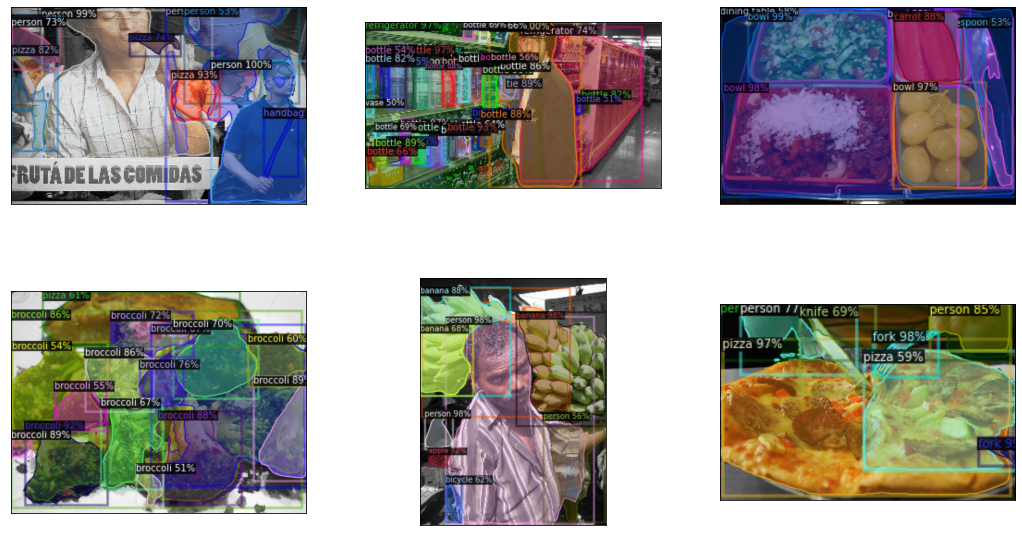

In [98]:
fig, axs = plt.subplots(x,y, figsize=(18,10), sharey=False,sharex=False)

for i in range(x):
    for j in range(y):
        axs[i,j].imshow(base_list[j+i*y].get_image(),interpolation='gaussian')
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
# fig.savefig("./io.pdf", bbox_inches="tight")
fig.savefig("./base_vis.pdf", bbox_inches="tight")

# Evaluate our model

In [10]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("lvis_train",)
cfg.DATASETS.TEST = ("lvis_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 1e-5  # pick a good LR
cfg.SOLVER.MAX_ITER = 25001#int(epochs*len(lvis_train_dict)/cfg.SOLVER.IMS_PER_BATCH)  # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.GAMMA = 0.1 # The iteration number to decrease learning rate by GAMMA.
cfg.SOLVER.STEPS = (12001,15001,18001)     #  decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 186  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.SOLVER.CHECKPOINT_PERIOD = 3000
cfg.TEST.EVAL_PERIOD = 1000
cfg.OUTPUT_DIR = './output_train'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
from detectron2.utils.visualizer import ColorMode
dataset_dicts = lvis_test_dict
my_list = []
random.seed(69)
for d in dataset_dicts[66:72]:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get('lvis_test'), 
                   scale=0.5, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    my_list.append(v.draw_instance_predictions(outputs["instances"].to("cpu")))

/home/ubuntu/anaconda3/envs/py36/lib/python3.6/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/ubuntu/anaconda3/envs/py36/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


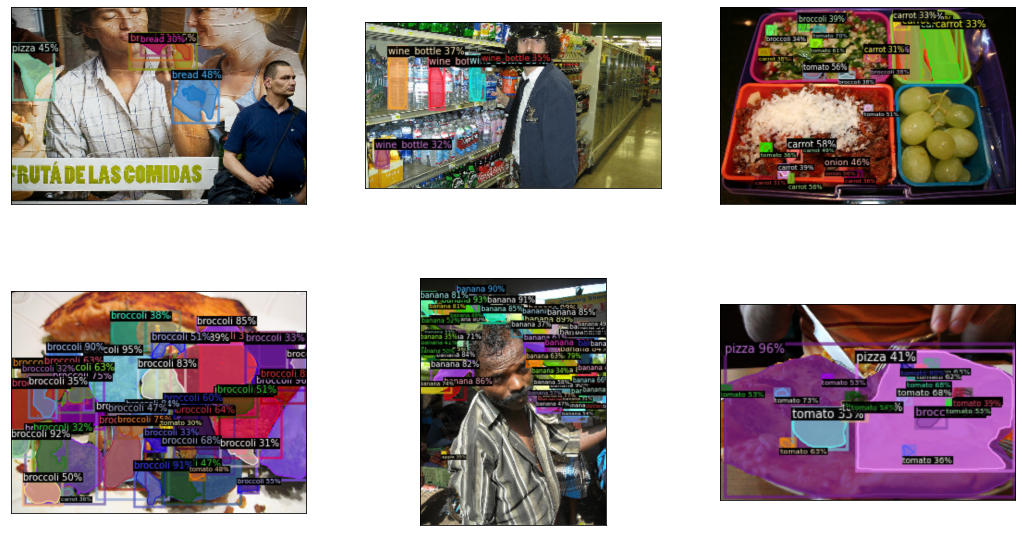

In [11]:
fig, axs = plt.subplots(x,y, figsize=(18,10), sharey=False,sharex=False)

for i in range(x):
    for j in range(y):
        axs[i,j].imshow(my_list[j+i*y].get_image(),interpolation='gaussian')
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
fig.savefig("./my_net_vis.pdf", bbox_inches="tight")

In [29]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [30]:
etestuator = COCOEvaluator("lvis_test", output_dir="./output_train")
test_loader = build_detection_test_loader(cfg, "lvis_test")
print(inference_on_dataset(predictor.model, test_loader, etestuator))
# another equitestent way to etestuate the model is to use `trainer.test`

[06/02 00:27:39 d2.evaluation.coco_evaluation]: Trying to convert 'lvis_test' to COCO format ...
WARNING [06/02 00:27:39 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output_train/lvis_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/02 00:27:39 d2.data.build]: Distribution of instances among all 186 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    alcohol    | 67           |    almond     | 162          |     apple     | 1538         |
|  applesauce   | 2            |    apricot    | 0            |   artichoke   | 11           |
|   asparagus   | 67           |    avocado    | 81           |     bagel     | 35           |
|    banana     | 4535         | batter_(food) | 1            |  beef_(food)  | 160          |
|  beer_bottle  | 102          |   be

In [3]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

metrics= load_json_arr('./output_train/metrics.json')

In [4]:
my_loss = []
val_loss = []
for d in metrics:
    if('total_loss' in d.keys()):
        my_loss.append(d['total_loss'])
    if('validation_loss' in d.keys()):
        val_loss.append(d['validation_loss'])
    

(0.0, 25000.0)

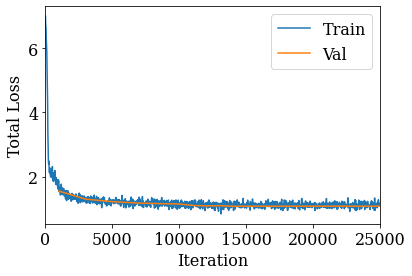

In [8]:

#Setup figure
plt.rcParams["font.family"] = "Serif"
# plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 16
plt.plot(np.arange(len(my_loss))*20,my_loss,label='Train')
plt.plot((np.arange(len(val_loss))+1)*1000,val_loss,label='Val')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.legend()
plt.xlim([0,25000])